In [27]:
# Goal: Use Caravan data set to compare results of boosting vs. other approaches.
rm(list=ls())
library(ISLR)      # Caravan dset
library(gbm)       # Boosting
library(class)     # knn

In [28]:
# Part a: Create train set of first 1,000 obs, test set of rest:
# Create a binary version of Purchase, and drop Purchase (since gbm requires 0/1):
table(Caravan$Purchase)
Caravan$Purchase_bin <- ifelse(Caravan$Purchase=='Yes', 1, 0)
Caravan_clean        <- subset(Caravan, select=-c(Purchase))
fix(Caravan_clean)
num_row     <- nrow(Caravan_clean)
train       <- Caravan_clean[1:1000,]
test        <- Caravan_clean[1001:num_row,]
print(nrow(train)); print(nrow(test)); print(num_row)


  No  Yes 
5474  348 

[1] 1000
[1] 4822
[1] 5822


In [29]:
# When I try to fit the below gbm, it tells me the below 2 features do not have
# any variation.  Here, I confirm that and then exclude them from train and test.
table(train$PVRAAUT)
table(train$AVRAAUT)
# Exclude both:
train_clean <- subset(train, select = -c(PVRAAUT,AVRAAUT))
test_clean  <- subset(test,  select = -c(PVRAAUT,AVRAAUT))


   0 
1000 


   0 
1000 

              var  rel.inf
PPERSAUT PPERSAUT 7.480819
MOPLHOOG MOPLHOOG 4.882054
MGODGE     MGODGE 4.838870
MKOOPKLA MKOOPKLA 4.507280
MOSTYPE   MOSTYPE 3.902338
MGODPR     MGODPR 3.547892


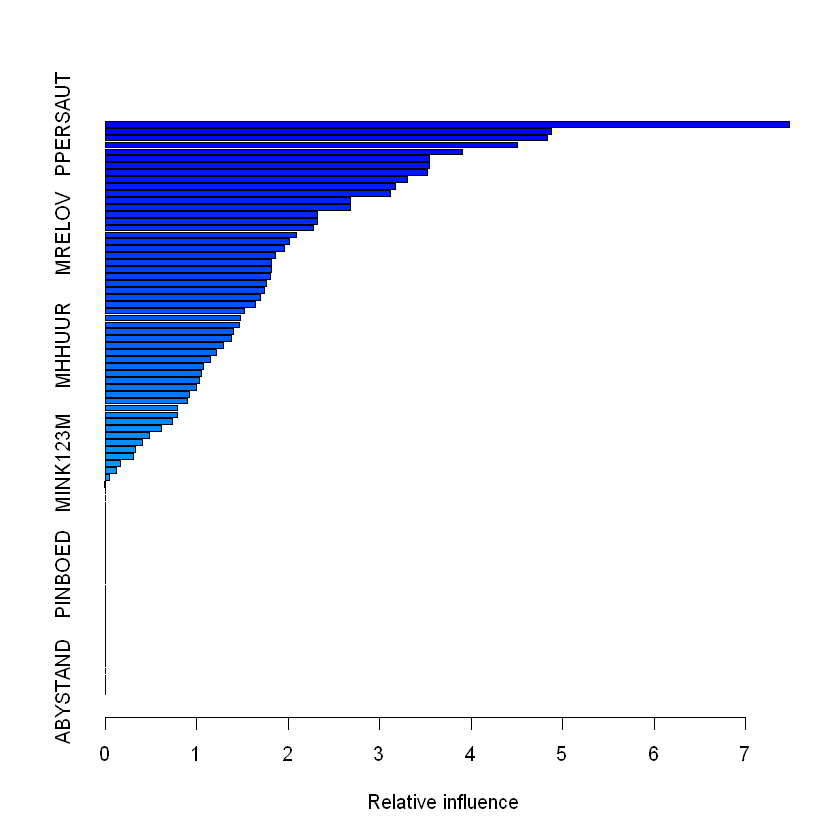

In [30]:
# Part b: Fit a boosted model to the train set:
set.seed(1)
# Parms:
num_trees <- 1000
shrinkage <- 0.01
# Fit model:
boost.mod <- gbm(Purchase_bin~., data=train_clean, n.trees=num_trees, distribution="bernoulli",
                    interaction.depth=4, shrinkage=shrinkage)
print(head(summary(boost.mod)))
# Clearly PPERSAUT is the most important variable, followed distantly by 
# MOPLHOOG, MGODGE, and MKOOPKLA.

In [31]:
# Part c: 
# Predict the prob of a person making a purchase:
boost.mod.pred           <- predict(boost.mod, newdata=test_clean, 
                                    n.trees=num_trees, type="response")
summary(boost.mod.pred)
# Predict a person will make a purchase if pred prob>0.2 
test_clean$Purchase_pred <- ifelse(boost.mod.pred>0.2, 'Pred_Yes', 'Pred_No')
# Form a confusion matrix:
conf_mat <- table(test_clean$Purchase_pred, test_clean$Purchase_bin)
print(conf_mat)
# Compute fraction of people predicted to make a purchase make one:
answer <- round(conf_mat[2,2]/sum(conf_mat[2,]),3)
print(answer)
# 13.6% of those predicted to actually make a purchase.

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002184 0.009556 0.018223 0.048722 0.046377 0.951933 

          
              0    1
  Pred_No  4336  258
  Pred_Yes  197   31
[1] 0.136


In [32]:
# Part c: Continued.
# Scale the data before applying KNN:
train_clean_scaled <- scale(train_clean[,1:83])  # Don't scale response var
test_clean_scaled  <- scale( test_clean[,1:83])  # Don't scale response var
# Apply KNN to this data set with arbitrary selection of K=5
set.seed(1)
knn.pred <- knn(train_clean_scaled, test_clean_scaled, train_clean[,84], k=5)
# Form a confusion matrix:
conf_mat <- table(knn.pred, test_clean$Purchase_bin)
print(conf_mat)
# Compute fraction of people predicted to make a purchase make one:
answer <- round(conf_mat[2,2]/sum(conf_mat[2,]),3)
print(answer)
# About 28.6% of predicted purchasers actually made a purchase.
# While this is higher than boosted model, clearly it predicts a much smaller
# absolute amount will be purchased.  Clearly, a normative decision needs to be
# made here to determine what is optimal: maximizing % correctly predicted or 
# absolute number of correct predictions?

        
knn.pred    0    1
       0 4513  281
       1   20    8
[1] 0.286


In [33]:
# Before we can apply logistic regression, I need to first remove two variables which
# cause singularity in the estimation matrix:
train_cleaner <- subset(train_clean, select = -c(AWERKT,AZEILPL))
test_cleaner  <- subset(test_clean,  select = -c(AWERKT,AZEILPL))
head(train_cleaner)

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase_bin
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0
6,23,1,2,1,5,0,5,0,5,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Part c: Continued again.
# Apply logistic regression to this data set:
set.seed(1)
logis.mod       <- glm(Purchase_bin~., data=train_cleaner, family=binomial)
summary(logis.mod)
logis.mod.pred  <- predict(logis.mod, newdata=test_cleaner, type="response")
# summary(logis.mod)
# sort(logis.mod$fitted.values)
# There is a warning message that fitted vals close to 0 or 1 occured.
# 1 predicted value of 1.0, and multiple predicted
# values that are very close to 0.  I don't think that invalidates the fit.
# I think the point of this excercise is that logistic regression will not perform
# well here, without some sort of variable selection being performed, because of so
# many predictor variables.
# Predict a person will make a purchase if pred prob>0.2 
test_cleaner$Purchase_pred <- ifelse(logis.mod.pred>0.2, 'Pred_Yes', 'Pred_No')
# Form a confusion matrix:
conf_mat <- table(test_cleaner$Purchase_pred, test_cleaner$Purchase_bin)
print(conf_mat)
# Compute fraction of people predicted to make a purchase make one:
answer <- round(conf_mat[2,2]/sum(conf_mat[2,]),3)
print(answer)
# About 14.2% of predicted purchasers actually made a purchase.  This is about 
# close to the boosted model but much less than KNN.  It predicts many more
# true postives, but at a lower correct prediction rate.  Again, it goes back to
# the question: what trade-offs are we willing to make here?

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = Purchase_bin ~ ., family = binomial, data = train_cleaner)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5422  -0.3307  -0.1710  -0.0766   3.3780  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)  2.561e+02  4.912e+04   0.005   0.9958  
MOSTYPE     -1.814e-02  1.366e-01  -0.133   0.8944  
MAANTHUI     7.131e-02  4.419e-01   0.161   0.8718  
MGEMOMV     -9.298e-01  4.201e-01  -2.213   0.0269 *
MGEMLEEF     4.187e-02  2.840e-01   0.147   0.8828  
MOSHOOFD     1.400e-01  6.127e-01   0.228   0.8193  
MGODRK      -7.230e-01  3.571e-01  -2.025   0.0429 *
MGODPR      -3.201e-01  3.608e-01  -0.887   0.3750  
MGODOV      -6.499e-01  3.221e-01  -2.018   0.0436 *
MGODGE      -2.773e-01  3.504e-01  -0.791   0.4287  
MRELGE       7.989e-01  4.116e-01   1.941   0.0522 .
MRELSA       6.917e-01  3.877e-01   1.784   0.0744 .
MRELOV       8.762e-01  4.205e-01   2.084   0.0372 *
MFALLEEN    -3.702e-01  3.743e-01  -0.989   0.322

          
              0    1
  Pred_No  4183  231
  Pred_Yes  350   58
[1] 0.142
